# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import dill
import pprint
from IPython.display import display as dis
from collections import Counter

from helper_functions import do_pca, scree_plot, plot_components, pca_results

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 110)

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Skim through Data_dictionary.md

# Seems like the table of contents is organized by spatial scale. For eg., details based on individual,
# building and zipcode. Given the number of features, probably many of them will not be useful.
# However, certain correlations between factors might be predictive.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [6]:
dis(azdias.head())
dis(azdias.info())
dis(azdias.shape)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,...,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,...,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,...,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,...,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,...,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

None

(891221, 85)

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# Fill missing values with NaN

#The new dataframe
azdias_fillnan = azdias.copy()

#Make sure that feat_info has the same number of rows as there are columns in the dataset
assert len(feat_info['attribute']) == len(azdias.columns)

#Iterate over column name and missing values in feat_info
for col, missing_values in zip(feat_info['attribute'],feat_info['missing_or_unknown']):
    
    #Identify columns with missing values and convert it into a list
    if missing_values == '[]':
        list_values = ''
    else:
        list_values = missing_values.strip('][').split(',')
    
    # Skip if no missing values
    if list_values == '':
        pass
    else: 
        #Placeholder for new column
        new = azdias[col]
        
        #Iterate over list of missing values, convert to int if it's a number, else to str
        for item in list_values:
            try:
                item = int(item)
            except ValueError:
                item = str(item)
                
            # Replace missing value with NaN
            new = new.mask(lambda x: x == item)
        
        #Assign to new dataframe
        azdias_fillnan[col] = new

assert azdias_fillnan.shape == azdias.shape
dis(azdias.head())
azdias_fillnan.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,...,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,...,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,...,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,...,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,...,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,...,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,4,NaN,10.0,0,NaN,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,0,3.0,...,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,1,1979.0,10.0,1,3.0,...,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,6,1957.0,1.0,0,2.0,...,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,5,1963.0,5.0,0,3.0,...,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [8]:
#Sanity check to assure missing values are converted
azdias_fillnan['CAMEO_INTL_2015'].value_counts()

51    133694
41     92336
24     91158
14     62884
43     56672
54     45391
25     39628
22     33155
23     26750
13     26336
45     26132
55     23955
52     20542
31     19024
34     18524
15     16974
44     14820
12     13249
35     10356
32     10354
33      9935
Name: CAMEO_INTL_2015, dtype: int64

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [11]:
# Perform an assessment of how much missing data there is in each column of the dataset.

#Percentage of NA values in each column
na_percent = ((azdias_fillnan.isna().sum()*100)/azdias_fillnan.shape[0]).sort_values(ascending=False)
na_percent.head(10)

TITEL_KZ          99.757636
AGER_TYP          76.955435
KK_KUNDENTYP      65.596749
KBA05_BAUMAX      53.468668
GEBURTSJAHR       44.020282
ALTER_HH          34.813699
REGIOTYP          17.735668
KKK               17.735668
W_KEIT_KIND_HH    16.605084
KBA05_ANTG4       14.959701
dtype: float64

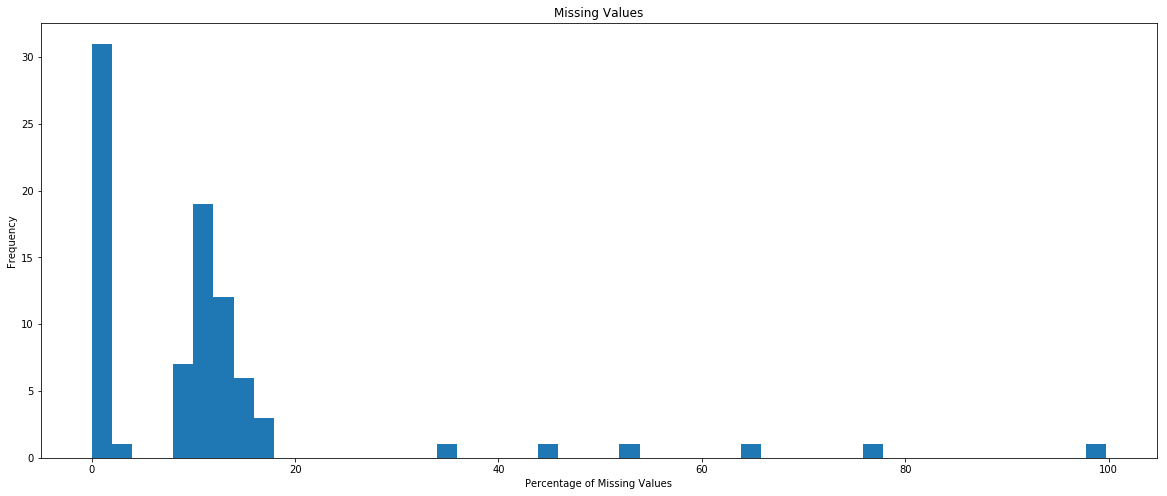

In [12]:
# Investigate patterns in the amount of missing data in each column.

# Plot a simple histogram
fig, ax = plt.subplots(figsize=(20, 8))
na_percent.plot(x=na_percent.index, y=na_percent,kind='hist',bins=50)
plt.title('Missing Values')

plt.xlabel('Percentage of Missing Values')
plt.show()

In [13]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

#From the histogram we can see that most of the columns have less than 20% missing data.These are useful.
#Here, those columns that have more than 30% missing data can be removed. That's a bit aggressive,
#but lets remove the outliers as instructed.

#Columns to remove
to_remove = na_percent[na_percent >20]

dis(to_remove)
dis(azdias_fillnan[to_remove.index].head(10))

TITEL_KZ        99.757636
AGER_TYP        76.955435
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
GEBURTSJAHR     44.020282
ALTER_HH        34.813699
dtype: float64

,TITEL_KZ,AGER_TYP,KK_KUNDENTYP,KBA05_BAUMAX,GEBURTSJAHR,ALTER_HH
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,5.0,1996.0,NaN
2,NaN,NaN,NaN,NaN,1979.0,17.0
3,NaN,2.0,NaN,1.0,1957.0,13.0
4,NaN,NaN,1.0,NaN,1963.0,20.0
5,NaN,3.0,3.0,NaN,1943.0,10.0
6,NaN,NaN,NaN,1.0,NaN,NaN
7,NaN,NaN,NaN,NaN,1964.0,14.0
8,NaN,NaN,NaN,NaN,1974.0,16.0
9,NaN,NaN,6.0,NaN,1975.0,17.0


In [14]:
#Looking for patterns in missing values

#Number of columns for each percentage of missing values
dis(na_percent.value_counts())

same_miss_val = {}
col_indices = {}

#Get the column names and indices for each percentage of missing values
for index, value in na_percent.value_counts().iteritems():
    if value != 1:
        a = set(na_percent[na_percent == index].index)
        same_miss_val[index] = a
        col_list = []
        for item in a:
            col_list.append(azdias_fillnan.columns.get_loc(str(item)))
            col_list.sort()
            col_indices[index] = col_list
            
[print(k,v) for k,v in col_indices.items()]
print('\n')
[print('NA %:',k,'\n',"Columns:",v,len(v),'\n') for k,v in same_miss_val.items()]

0.000000     24
13.073637     7
0.544646      6
14.959701     6
10.451729     4
8.247000      4
10.518154     3
11.147852     3
12.476816     3
10.926022     2
8.728699      2
17.735668     2
12.136608     1
10.914689     1
53.468668     1
2.058749      1
76.955435     1
16.605084     1
12.153551     1
10.452514     1
10.954859     1
11.871354     1
0.323264      1
10.611509     1
10.884842     1
44.020282     1
34.813699     1
65.596749     1
8.299737      1
11.176913     1
99.757636     1
dtype: int64

0.0 [2, 4, 5, 6, 7, 8, 9, 10, 13, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 42]
13.073637178657146 [75, 76, 77, 78, 79, 80, 81]
0.5446460529992 [3, 12, 19, 20, 23, 72]
14.959701353536328 [60, 61, 62, 63, 65, 71]
10.451728583594866 [52, 54, 55, 56]
8.247000463409188 [39, 44, 45, 49]
10.518154307405235 [66, 67, 68]
11.147852216229195 [57, 58, 59]
12.476815514894735 [14, 38, 41]
10.926021716274638 [82, 84]
8.728699166648902 [17, 18]
17.73566825736826 [70, 73]


NA %: 0.0 
 Columns: {'ANREDE_KZ', 'FINANZTYP', 'SEMIO_KULT', 'FINANZ_SPARER', 'SEMIO_ERL', 'SEMIO_FAM', 'SEMIO_MAT', 'SEMIO_PFLICHT', 'GREEN_AVANTGARDE', 'SEMIO_REL', 'FINANZ_VORSORGER', 'SEMIO_DOM', 'SEMIO_KRIT', 'FINANZ_MINIMALIST', 'SEMIO_KAEM', 'FINANZ_HAUSBAUER', 'SEMIO_LUST', 'SEMIO_VERT', 'SEMIO_RAT', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_ANLEGER', 'SEMIO_SOZ', 'ZABEOTYP', 'SEMIO_TRADV'} 24 

NA %: 13.073637178657146 
 Columns: {'PLZ8_ANTG4', 'PLZ8_ANTG1', 'PLZ8_GBZ', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_HHZ', 'PLZ8_B

[None, None, None, None, None, None, None, None, None, None, None, None]

In [15]:
# Dropping Columns

azdias_dropped = azdias_fillnan.drop(to_remove.index, axis=1)
azdias_dropped.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

<b> 1. Columns that have >20% missing data.

| Column Name    | Percent of missing data | Description                                                                                                                                                                           |
|----------------|-------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| AGER_TYP       | 76.955435               | Seems to be a classification of elderly, explaining the large number of NAN values for the non-elderly population. Might be useful, but there are other columns that describe elderly |
| GEBURTSJAHR    | 44.020282               | Year of birth. Might be useful, but other columns encapsulate age data.                                                                                                               |
| TITEL_KZ       | 99.757636               | Academic title flag. Probably unimportant                                                                                                                                             |
| ALTER_HH       | 34.813699               | Birthdate of head of household. Probably unimportant.                                                                                                                                 |
| KK_KUNDENTYP   | 65.596749               | Consumer pattern over last 12 months. This seems to be an important feature, but the amount of data is too small.                                                                               |
| KBA05_BAUMAX   | 53.468668               | Number of 1-2 family houses. Probably unimportant                                                                                                                                     |



<b> 2. Patterns

Amongst the columns with the same percentage of missing values, we can see that their column indices are almost continuous. On inspection of the data dictionary we can see that these columns are just the same variable but with different ordinal values for each category of the variable. For eg. 'FINANZ' and 'SEMIO' columns represent financial and personality typology respectively and each column represents the likehood of one ordinal value of that variable. Also, these columns could be variables taken from the same spatial resolution.


These two features explain the reason why many of the columns have the same percentage of missing values.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [22]:
# How much data is missing in each row of the dataset?

azdias_dropped['n_missing'] = azdias_dropped.isnull().sum(axis=1)

azdias_dropped['n_missing'].value_counts().sort_index(ascending =False)

49         2
48         1
47     45578
45       494
44       155
43     27369
42        21
41       356
40       137
39        77
38       421
37       538
36        84
35      3911
34     10816
33      2985
32       206
31         3
30         6
29        12
28         5
27        24
26        59
25        55
24        69
23       132
22       129
21       150
20       349
19      1180
18       428
17       677
16      2505
15      4743
14      2243
13      3255
12       766
11      1127
10      5410
9       3042
8      24592
7      13714
6      13771
5      22515
4      12607
3      17629
2      27926
1      15738
0     623209
Name: n_missing, dtype: int64

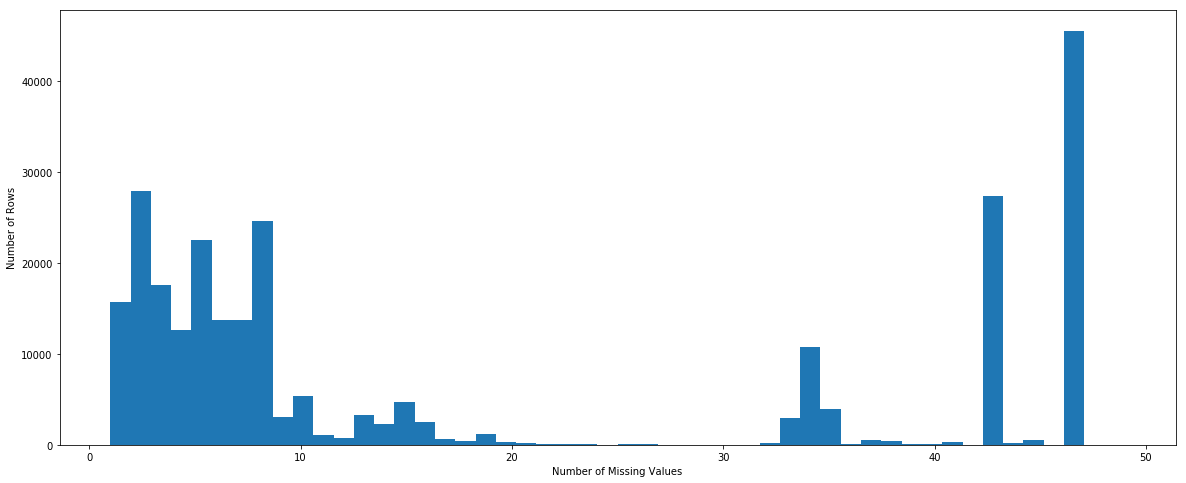

In [23]:
#The most natural division seems to be at 19. But lets confirm it with a plot

#Leave out rows with no missing values
row_missing_counts = azdias_dropped['n_missing'].mask(azdias_dropped['n_missing'] == 0)

#Plot the graph
fig, ax = plt.subplots(figsize=(20, 8))
row_missing_counts.plot(kind='hist',bins=50)

plt.xlabel('Number of Missing Values')
plt.ylabel('Number of Rows')

plt.show()


In [24]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

#So our data is can be neatly divided based on rows with missing values <=19 and >19
less_than19 = azdias_dropped[azdias_dropped['n_missing'] <= 19]
more_than19 = azdias_dropped[azdias_dropped['n_missing'] > 19]

#Now we can drop the n_missing column from both the datasets
less_than19 = less_than19.drop('n_missing',axis=1)
more_than19 = more_than19.drop('n_missing',axis=1)


dis(less_than19.head(), more_than19.head())
print(less_than19.shape, more_than19.shape)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,...,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,...,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,...,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,...,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,...,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,1.0,0,3.0,8.0,2.0,...,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,...,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,10.0,0,NaN,15.0,4.0,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2.0,1,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,3.0,1,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,2.0,1,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,3.0,2,6.0,3,4,3,5,5,3,4,5.0,0,NaN,NaN,NaN,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(797077, 79) (94144, 79)


In [25]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

#Function to plot the same column of data between the two datasets with smaller 
#and larger number of missing values
def compare_plot (column,df1=less_than19, df2=more_than19):
    fig, ax =plt.subplots(1,2,figsize=(8, 8))
    sns.countplot(df1.iloc[:,column], ax=ax[0])
    sns.countplot(df2.iloc[:,column], ax=ax[1])
    plt.subplots_adjust(wspace= 0.5)
    fig.show()

#From our earlier analysis, we can pick the columns with lower number of missing values
    
# 0.0 [2, 4, 5, 6, 7, 8, 9, 10, 13, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 42]
# 13.073637178657146 [75, 76, 77, 78, 79, 80, 81]
# 14.959701353536328 [60, 61, 62, 63, 65, 71]
# 0.5446460529992 [3, 12, 19, 20, 23, 72]
# 10.451728583594866 [52, 54, 55, 56]
# 8.247000463409188 [39, 44, 45, 49]
# 10.518154307405235 [66, 67, 68]
# 11.147852216229195 [57, 58, 59]
# 12.476815514894735 [14, 38, 41]
# 10.926021716274638 [82, 84]
# 8.728699166648902 [17, 18]
# 17.73566825736826 [70, 73]

column_indices = [2,42,72,39,17]

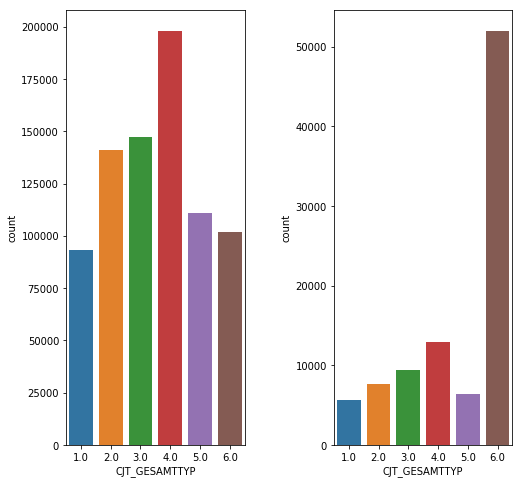

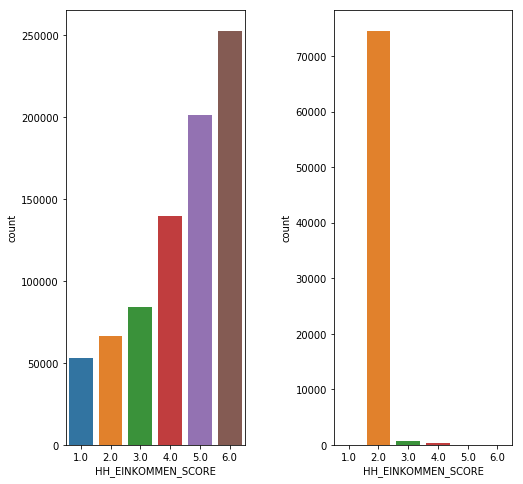

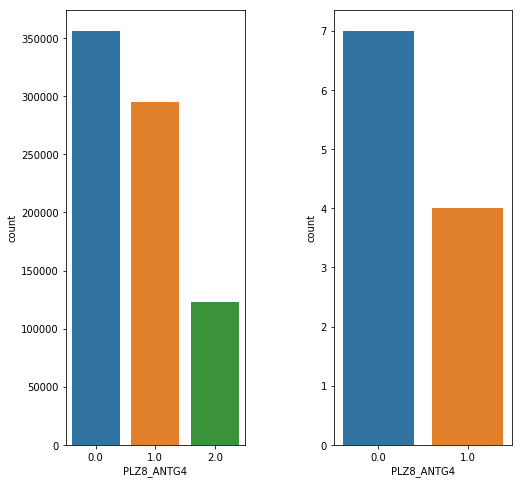

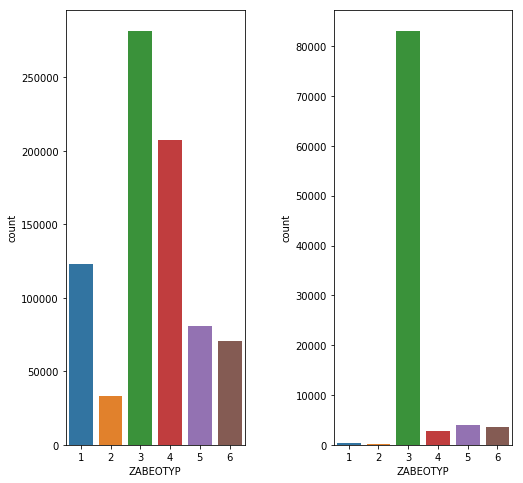

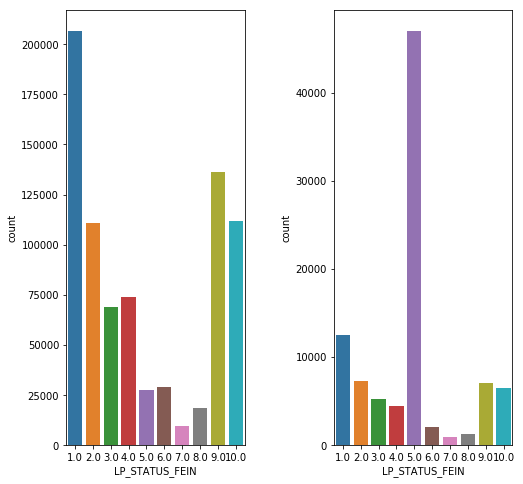

In [26]:
for i in column_indices:
    compare_plot(column=i)

#### Discussion 1.1.3: Assess Missing Data in Each Row

Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?

<b> Yes. For each of the 5 columns in which we compared the distribution of values across the two datasets, we observed significantly different distributions.

<b> This implies that there is something different or special about the dataset that has a larger number of missing values. It could be that the data points are acquired differently or that they are concentrated in a certain feature (for eg., region) which makes them have higher number of missing values as well as different features compared to the rest of the dataset.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [27]:
# How many features are there of each data type?

dis(feat_info.head())
feat_info['type'].value_counts()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [28]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

#First, get the column names for the categorical variables
categ_var = feat_info['attribute'][feat_info['type'] == 'categorical'].tolist()

#Filter out the columns that have already been removed
categ_var = [x for x in categ_var if x not in to_remove]

#For each of these variables, lets identify how many classes they have
binary_nonnum = []
binary_num = []
multi = []

for index,column in less_than19[categ_var].iteritems():
    classes = len(column.value_counts())
    if classes == 2:
        if column.value_counts().index.dtype not in ['int64','float64']:
            binary_nonnum.append(column.name)
        else:
            binary_num.append(column.name)
    if classes >2:
        multi.append(column.name)
        
print(binary_nonnum)
print(binary_num)
print(multi)

#The binary non-numerical category differentiates between east and west germany, we can reencode
less_than19['OST_WEST_KZ'].loc[less_than19['OST_WEST_KZ'] == 'W'] = 1
less_than19['OST_WEST_KZ'].loc[less_than19['OST_WEST_KZ'] == 'O'] = 0

['OST_WEST_KZ']
['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP']
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [29]:
# Re-encode categorical variable(s) to be kept in the analysis.
#Now we can one-hot encode the multiclass variables
less_than19 = pd.get_dummies(less_than19,columns=multi)
print(less_than19.shape)

(797077, 194)


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

1. Binary numeric variables were kept as is.
2. Binary non-numeric variables were converted to their numeric equivalents.
3. Multi-class varialbes were re-encoded through one-hot encoding.

None of the columns were dropped in this step.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [30]:
# First, lets investigate the classes of the mixed variables

dis(feat_info.head())
feat_info['type'].value_counts()

#Get the mixed variable columns
mixed_var = feat_info['attribute'][feat_info['type'] == 'mixed'].tolist()

#Filter out the columns that have already been removed
mixed_var = [x for x in mixed_var if x not in to_remove]

for i in mixed_var:
    print(i,less_than19[i].unique())

    
#For sake of simplicity, we will drop those columns that have not been mentioned above
mixed_var_r = list(set(mixed_var) - set(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015']))
dis(mixed_var_r)

azdias_ = less_than19.drop(mixed_var_r, axis=1)
azdias_.shape

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


LP_LEBENSPHASE_FEIN [ 21.   3.  nan  32.   8.   2.   5.  10.   4.   6.  23.  12.  20.   1.  11.
  25.  13.  18.  31.  38.  35.  30.   7.  22.  14.  29.  24.  28.  37.  26.
  39.  27.  36.   9.  34.  33.  15.  40.  16.  19.  17.]
LP_LEBENSPHASE_GROB [  6.   1.  nan  10.   2.   3.   5.   7.  12.  11.   9.   4.   8.]
PRAEGENDE_JUGENDJAHRE [ 14.  15.   8.   3.  10.  11.   5.   9.   6.   4.  nan   2.   1.  12.  13.
   7.]
WOHNLAGE [ 4.  2.  7.  3.  5.  1.  8.  0.]
CAMEO_INTL_2015 ['51' '24' '12' '43' '54' '22' '14' '13' '15' '33' '41' '34' '55' nan '25'
 '23' '31' '52' '35' '45' '44' '32']
PLZ8_BAUMAX [  1.   2.  nan   4.   5.   3.]


['LP_LEBENSPHASE_FEIN', 'PLZ8_BAUMAX', 'WOHNLAGE', 'LP_LEBENSPHASE_GROB']

(797077, 190)

In [31]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

#We need to know the features of each value to be able to isolate them. Get that info from Dictionary.md

pj_dict={
1: "40s - war years (Mainstream, E+W)",
2: "40s - reconstruction years (Avantgarde, E+W)",
3: "50s - economic miracle (Mainstream, E+W)",
4: "50s - milk bar / Individualisation (Avantgarde, E+W)",
5: "60s - economic miracle (Mainstream, E+W)",
6: "60s - generation 68 / student protestors (Avantgarde, W)",
7: "60s - opponents to the building of the Wall (Avantgarde, E)",
8: "70s - family orientation (Mainstream, E+W)",
9: "70s - peace movement (Avantgarde, E+W)",
10: "80s - Generation Golf (Mainstream, W)",
11: "80s - ecological awareness (Avantgarde, W)",
12: "80s - FDJ / communist party youth organisation (Mainstream, E)",
13: "80s - Swords into ploughshares (Avantgarde, E)",
14: "90s - digital media kids (Mainstream, E+W)",
15: "90s - ecological awareness (Avantgarde, E+W)"
}

#Get a dictionary that maps from the original values to the values in the new variables
decades = {'40s':1,'50s':2,'60s':3,'70s':4,'80s':5,'90s':6}
mm = {'Avantgarde':0,'Mainstream':1}

dec_convert = {}
mm_convert = {}

for kpj,vpj in pj_dict.items():
    for kd,vd in decades.items():
        if kd in vpj:
            dec_convert[kpj] = vd
    for kmm, vmm in mm.items():
        if kmm in vpj:
            mm_convert[kpj] = vmm
        
print(dec_convert)
print(mm_convert)

#Reassign the values in the new dictionaries
pj_col = azdias_['PRAEGENDE_JUGENDJAHRE']

azdias_['PRAEGENDE_JUGENDJAHRE_DEC'] = pj_col
azdias_['PRAEGENDE_JUGENDJAHRE_MOV'] = pj_col

azdias_['PRAEGENDE_JUGENDJAHRE_DEC'] = azdias_['PRAEGENDE_JUGENDJAHRE_DEC'].replace(dec_convert)
azdias_['PRAEGENDE_JUGENDJAHRE_MOV'] = azdias_['PRAEGENDE_JUGENDJAHRE_MOV'].replace(mm_convert)
        
dis(azdias_['PRAEGENDE_JUGENDJAHRE_DEC'].value_counts(),
      azdias_['PRAEGENDE_JUGENDJAHRE_MOV'].value_counts(),
      pj_col.value_counts())

#Delete the old column
azdias_ = azdias_.drop(columns='PRAEGENDE_JUGENDJAHRE')
azdias_.shape

{1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 7: 3, 8: 4, 9: 4, 10: 5, 11: 5, 12: 5, 13: 5, 14: 6, 15: 6}
{1: 1, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 0, 8: 1, 9: 0, 10: 1, 11: 0, 12: 1, 13: 0, 14: 1, 15: 0}


6.0    225333
4.0    175064
5.0    151670
3.0    114307
2.0     74261
1.0     28118
Name: PRAEGENDE_JUGENDJAHRE_DEC, dtype: int64

1.0    593618
0.0    175135
Name: PRAEGENDE_JUGENDJAHRE_MOV, dtype: int64

14.0    182833
8.0     141504
10.0     85746
5.0      84649
3.0      53811
15.0     42500
11.0     35729
9.0      33560
6.0      25649
12.0     24436
1.0      20639
4.0      20450
2.0       7479
13.0      5759
7.0       4009
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

(797077, 191)

In [32]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

#Getting the feature mapping dictionary
cameo_dict={
11:'Wealthy Households Pre-Family Couples & Singles',
12:'Wealthy Households Young Couples With Children',
13:'Wealthy Households Families With School Age Children',
14:'Wealthy Households Older Families & Mature Couples',
15:'Wealthy Households Elders In Retirement',
21:'Prosperous Households Pre-Family Couples & Singles',
22:'Prosperous Households Young Couples With Children',
23:'Prosperous Households Families With School Age Children',
24:'Prosperous Households Older Families & Mature Couples',
25:'Prosperous Households Elders In Retirement',
31:'Comfortable Households Pre-Family Couples & Singles',
32:'Comfortable Households Young Couples With Children',
33:'Comfortable Households Families With School Age Children',
34:'Comfortable Households Older Families & Mature Couples',
35:'Comfortable Households Elders In Retirement',
41:'Less Affluent Households Pre-Family Couples & Singles',
42:'Less Affluent Households Young Couples With Children',
43:'Less Affluent Households Families With School Age Children',
44:'Less Affluent Households Older Families & Mature Couples',
45:'Less Affluent Households Elders In Retirement',
51:'Poorer Households Pre-Family Couples & Singles',
52:'Poorer Households Young Couples With Children',
53:'Poorer Households Families With School Age Children',
54:'Poorer Households Older Families & Mature Couples',
55:'Poorer Households Elders In Retirement'
}

#Get a dictionary that maps from the original values to the values in the new variables
lifestage_dict= {
'Pre-Family Couples & Singles' :1 ,
'Young Couples With Children': 2,
'Families With School Age Children': 3,
'Older Families & Mature Couples': 4,
'Elders In Retirement':5}

wealth_dict = {
'Wealthy Households': 1,
'Prosperous Households': 2,
'Comfortable Households': 3 ,
'Less Affluent Households': 4,
'Poorer Households': 5}

lifestage_convert = {}
wealth_convert = {}

for kpj,vpj in cameo_dict.items():
    for kd,vd in lifestage_dict.items():
        if kd in vpj:
            lifestage_convert[kpj] = vd
    for kmm, vmm in wealth_dict.items():
        if kmm in vpj:
            wealth_convert[kpj] = vmm

dis(lifestage_convert,wealth_convert)

#Reassign the values in the new dictionaries
cameo_col = azdias_['CAMEO_INTL_2015'].astype('float64')

azdias_['CAMEO_INTL_2015_LS'] = cameo_col
azdias_['CAMEO_INTL_2015_WE'] = cameo_col

azdias_['CAMEO_INTL_2015_LS'].replace(lifestage_convert, inplace = True)
azdias_['CAMEO_INTL_2015_WE'].replace(wealth_convert, inplace = True)
        
dis(azdias_['CAMEO_INTL_2015_LS'].value_counts(),
      azdias_['CAMEO_INTL_2015_WE'].value_counts(),
      cameo_col.value_counts())

#Delete the old column
azdias_ = azdias_.drop(columns='CAMEO_INTL_2015')
azdias_.shape

{11: 1,
 12: 2,
 13: 3,
 14: 4,
 15: 5,
 21: 1,
 22: 2,
 23: 3,
 24: 4,
 25: 5,
 31: 1,
 32: 2,
 33: 3,
 34: 4,
 35: 5,
 41: 1,
 42: 2,
 43: 3,
 44: 4,
 45: 5,
 51: 1,
 52: 2,
 53: 3,
 54: 4,
 55: 5}

{11: 1,
 12: 1,
 13: 1,
 14: 1,
 15: 1,
 21: 2,
 22: 2,
 23: 2,
 24: 2,
 25: 2,
 31: 3,
 32: 3,
 33: 3,
 34: 3,
 35: 3,
 41: 4,
 42: 4,
 43: 4,
 44: 4,
 45: 4,
 51: 5,
 52: 5,
 53: 5,
 54: 5,
 55: 5}

1.0    244914
4.0    232595
3.0    119508
5.0    116957
2.0     77236
Name: CAMEO_INTL_2015_LS, dtype: int64

5.0    223496
2.0    190426
4.0    189876
1.0    119329
3.0     68083
Name: CAMEO_INTL_2015_WE, dtype: int64

51.0    133665
41.0     92297
24.0     91070
14.0     62833
43.0     56642
54.0     45366
25.0     39593
22.0     33128
23.0     26635
13.0     26305
45.0     26122
55.0     23928
52.0     20537
31.0     18952
34.0     18511
15.0     16965
44.0     14815
12.0     13226
35.0     10349
32.0     10345
33.0      9926
Name: CAMEO_INTL_2015, dtype: int64

(797077, 192)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

<b> 1. The mixed variable columns "PRAEGENDE_JUGENDJAHRE" and "CAMEO_INTL_2015" were split into their component variables, each having their own columns. Since the resulting columns were either binary variables or interval variables (to be treated as numeric), no further re-encoding was performed.

<b> 2. For the sake of simplicity the other mixed variables have been dropped.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [33]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

azdias_.info()

#Most of the steps mentioned have already been performed
#We have also confirmed that all the columns are numeric

<class 'pandas.core.frame.DataFrame'>
Int64Index: 797077 entries, 1 to 891220
Columns: 192 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_WE
dtypes: float64(41), int64(23), uint8(128)
memory usage: 512.6 MB


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [34]:
def clean_data(df, cols_to_remove=to_remove,missing_perrow=19):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
           cols_to_remove: List of columns to remove
           missing_perrow: Int, number of missing values per row (inclusive) that is tolerable
    
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """

    
    #### convert missing value codes into NaNs, ...
    #### Fill missing values with NaN

    
    #The new dataframe
    print('The shape of the original dataframe:',df.shape)
    df_fillnan = df.copy()

    #Make sure that feat_info has the same number of rows as there are columns in the dataset
    assert len(feat_info['attribute']) == len(df.columns)

    #Iterate over column name and missing values in feat_info
    for col, missing_values in zip(feat_info['attribute'],feat_info['missing_or_unknown']):

        #Identify columns with missing values and convert it into a list
        if missing_values == '[]':
            list_values = ''
        else:
            list_values = missing_values.strip('][').split(',')

        # Skip if no missing values
        if list_values == '':
            pass
        else: 
            #Placeholder for new column
            new = df[col]

            #Iterate over list of missing values, convert to int if it's a number, else to str
            for item in list_values:
                try:
                    item = int(item)
                except ValueError:
                    item = str(item)

                # Replace missing value with NaN
                new = new.mask(lambda x: x == item)

            #Assign to new dataframe
            df_fillnan[col] = new

    assert df_fillnan.shape == df.shape

    dis('The original dataframe:', df.head())
    dis('dataframe with missing values removed:',df_fillnan.head())
    
    #### remove selected columns and rows, ...
    
    # removed columns
    dis('columns to remove:', cols_to_remove)
    
    df_dropped = df_fillnan.drop(cols_to_remove.index, axis=1)
    dis('Shape after dropping columns:',df_dropped.shape)
    
    #remove rows
    df_dropped['n_missing'] = df_dropped.isnull().sum(axis=1)
    
    less_than = df_dropped[df_dropped['n_missing'] <= missing_perrow]
    more_than = df_dropped[df_dropped['n_missing'] > missing_perrow]

    #Now we can drop the n_missing column from both the datasets
    less_than = less_than.drop('n_missing',axis=1)
    more_than = more_than.drop('n_missing',axis=1)
    
    print('Shape after dropping rows:',less_than.shape)

    
    ##### select, re-encode, and engineer column values.
    
    ####Re-encode categorical variables
    
    categ_var = feat_info['attribute'][feat_info['type'] == 'categorical'].tolist()

    #Filter out the columns that have already been removed
    categ_var = [x for x in categ_var if x not in to_remove]

    #For each of these variables, lets identify how many classes they have
    binary_nonnum = []
    binary_num = []
    multi = []

    for index,column in less_than[categ_var].iteritems():
        classes = len(column.value_counts())
        if classes == 2:
            if column.value_counts().index.dtype not in ['int64','float64']:
                binary_nonnum.append(column.name)
            else:
                binary_num.append(column.name)
        if classes >2:
            multi.append(column.name)

    #The binary non-numerical category differentiates between east and west germany, we can reencode
    less_than['OST_WEST_KZ'].loc[less_than['OST_WEST_KZ'] == 'W'] = 1
    less_than['OST_WEST_KZ'].loc[less_than['OST_WEST_KZ'] == 'O'] = 0
    
    #Now we can one-hot encode the multiclass variables
    less_than = pd.get_dummies(less_than,columns=multi)
    print('Shape after dealing with categoricals:', less_than.shape)
    
    
    
    #### Re-encode the 2 selected mixed variables
    
    
    #Get the mixed variable columns
    mixed_var = feat_info['attribute'][feat_info['type'] == 'mixed'].tolist()

    #Filter out the columns that have already been removed
    mixed_var = [x for x in mixed_var if x not in to_remove]

    #For sake of simplicity, we will drop those columns that have not been mentioned above
    mixed_var_r = list(set(mixed_var) - set(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015']))

    df_ = less_than.drop(mixed_var_r, axis=1)
    print('Shape after removing 4 mixed columns:',df_.shape)
    
    #PRAEGENDE_JUGENDJAHRE
    #We need to know the features of each value to be able to isolate them. Get that info from Dictionary.md
    pj_dict={
    1: "40s - war years (Mainstream, E+W)",
    2: "40s - reconstruction years (Avantgarde, E+W)",
    3: "50s - economic miracle (Mainstream, E+W)",
    4: "50s - milk bar / Individualisation (Avantgarde, E+W)",
    5: "60s - economic miracle (Mainstream, E+W)",
    6: "60s - generation 68 / student protestors (Avantgarde, W)",
    7: "60s - opponents to the building of the Wall (Avantgarde, E)",
    8: "70s - family orientation (Mainstream, E+W)",
    9: "70s - peace movement (Avantgarde, E+W)",
    10: "80s - Generation Golf (Mainstream, W)",
    11: "80s - ecological awareness (Avantgarde, W)",
    12: "80s - FDJ / communist party youth organisation (Mainstream, E)",
    13: "80s - Swords into ploughshares (Avantgarde, E)",
    14: "90s - digital media kids (Mainstream, E+W)",
    15: "90s - ecological awareness (Avantgarde, E+W)"
    }

    #Get a dictionary that maps from the original values to the values in the new variables
    decades = {'40s':1,'50s':2,'60s':3,'70s':4,'80s':5,'90s':6}
    mm = {'Avantgarde':0,'Mainstream':1}

    dec_convert = {}
    mm_convert = {}

    for kpj,vpj in pj_dict.items():
        for kd,vd in decades.items():
            if kd in vpj:
                dec_convert[kpj] = vd
        for kmm, vmm in mm.items():
            if kmm in vpj:
                mm_convert[kpj] = vmm

    print(dec_convert)
    print(mm_convert)

    #Reassign the values in the new dictionaries
    pj_col = df_['PRAEGENDE_JUGENDJAHRE']

    df_['PRAEGENDE_JUGENDJAHRE_DEC'] = pj_col
    df_['PRAEGENDE_JUGENDJAHRE_MOV'] = pj_col

    df_['PRAEGENDE_JUGENDJAHRE_DEC'] = df_['PRAEGENDE_JUGENDJAHRE_DEC'].replace(dec_convert)
    df_['PRAEGENDE_JUGENDJAHRE_MOV'] = df_['PRAEGENDE_JUGENDJAHRE_MOV'].replace(mm_convert)

    #Delete the old column
    df_ = df_.drop(columns='PRAEGENDE_JUGENDJAHRE')

    # CAMEO_INTL_2015
    #Getting the feature mapping dictionary
    cameo_dict={
    11:'Wealthy Households Pre-Family Couples & Singles',
    12:'Wealthy Households Young Couples With Children',
    13:'Wealthy Households Families With School Age Children',
    14:'Wealthy Households Older Families & Mature Couples',
    15:'Wealthy Households Elders In Retirement',
    21:'Prosperous Households Pre-Family Couples & Singles',
    22:'Prosperous Households Young Couples With Children',
    23:'Prosperous Households Families With School Age Children',
    24:'Prosperous Households Older Families & Mature Couples',
    25:'Prosperous Households Elders In Retirement',
    31:'Comfortable Households Pre-Family Couples & Singles',
    32:'Comfortable Households Young Couples With Children',
    33:'Comfortable Households Families With School Age Children',
    34:'Comfortable Households Older Families & Mature Couples',
    35:'Comfortable Households Elders In Retirement',
    41:'Less Affluent Households Pre-Family Couples & Singles',
    42:'Less Affluent Households Young Couples With Children',
    43:'Less Affluent Households Families With School Age Children',
    44:'Less Affluent Households Older Families & Mature Couples',
    45:'Less Affluent Households Elders In Retirement',
    51:'Poorer Households Pre-Family Couples & Singles',
    52:'Poorer Households Young Couples With Children',
    53:'Poorer Households Families With School Age Children',
    54:'Poorer Households Older Families & Mature Couples',
    55:'Poorer Households Elders In Retirement'
    }

    #Get a dictionary that maps from the original values to the values in the new variables
    lifestage_dict= {
    'Pre-Family Couples & Singles' :1 ,
    'Young Couples With Children': 2,
    'Families With School Age Children': 3,
    'Older Families & Mature Couples': 4,
    'Elders In Retirement':5}

    wealth_dict = {
    'Wealthy Households': 1,
    'Prosperous Households': 2,
    'Comfortable Households': 3 ,
    'Less Affluent Households': 4,
    'Poorer Households': 5}

    lifestage_convert = {}
    wealth_convert = {}

    for kpj,vpj in cameo_dict.items():
        for kd,vd in lifestage_dict.items():
            if kd in vpj:
                lifestage_convert[kpj] = vd
        for kmm, vmm in wealth_dict.items():
            if kmm in vpj:
                wealth_convert[kpj] = vmm

    #Reassign the values in the new dictionaries
    cameo_col = df_['CAMEO_INTL_2015'].astype('float64')

    df_['CAMEO_INTL_2015_LS'] = cameo_col
    df_['CAMEO_INTL_2015_WE'] = cameo_col

    df_['CAMEO_INTL_2015_LS'].replace(lifestage_convert, inplace = True)
    df_['CAMEO_INTL_2015_WE'].replace(wealth_convert, inplace = True)

    #Delete the old column
    df_ = df_.drop(columns='CAMEO_INTL_2015')
    
    print('Shape after reencoding mixed variables:',df_.shape)
    

    # Return the cleaned dataframe.
    return df_, more_than    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [35]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

print(100*(azdias_.size - azdias_.count().sum())/azdias_.size)

#The number of missing values is about 0.5%. Imputing is the standard option.

#Applying mean imputation
azdias_clean = azdias_.fillna(azdias_.mean())

#Confirming that there are no nan values
azdias_clean.isnull().values.any()

0.487455519772


False

In [36]:
# Apply feature scaling to the general population demographics data.
scale = StandardScaler()

azdias_scaled = pd.DataFrame(scale.fit_transform(azdias_clean),columns = azdias_clean.columns)
dis(azdias_clean.head())
azdias_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,...,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DEC,PRAEGENDE_JUGENDJAHRE_MOV,CAMEO_INTL_2015_LS,CAMEO_INTL_2015_WE
1,1.0,2,1,5,2,5,4,5,0,3.0,1.0,5,4,4,3,...,0,0,1,0,0,0,0,0,0,0,0,6.0,1.0,1.0,5.0
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,4,1,3,3,...,0,0,0,0,0,0,0,0,0,0,0,6.0,0.0,4.0,2.0
3,4.0,2,4,2,5,2,1,2,0,2.0,2.0,5,1,2,1,...,0,0,0,0,0,0,0,0,0,0,0,4.0,1.0,2.0,1.0
4,3.0,1,4,3,4,1,3,2,0,3.0,5.0,6,4,4,2,...,0,0,0,0,0,0,0,0,0,0,0,4.0,1.0,3.0,4.0
5,1.0,2,3,1,5,2,2,5,0,3.0,3.0,2,4,7,4,...,0,0,0,0,1,0,0,0,0,0,0,2.0,1.0,4.0,5.0


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,...,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DEC,PRAEGENDE_JUGENDJAHRE_MOV,CAMEO_INTL_2015_LS,CAMEO_INTL_2015_WE
0,-1.765596,0.958121,-1.494463,1.538139,-1.040664,1.466401,0.959974,1.338532,-0.530654,1.085338,-1.684255,0.442419,-0.059134,0.003319,-0.463253,...,-0.082041,-0.076412,3.768761,-0.209209,-0.201087,-0.150111,-0.162625,-0.189607,-0.179893,-0.192884,-0.089706,1.165504,0.553082,-1.265981,1.190696
1,0.201448,0.958121,-1.494463,0.864753,-1.766903,-0.570914,0.245238,1.338532,1.884467,1.085338,-0.305234,-0.072758,-1.626956,-0.520178,-0.463253,...,-0.082041,-0.076412,-0.265339,-0.209209,-0.201087,-0.150111,-0.162625,-0.189607,-0.179893,-0.192884,-0.089706,1.165504,-1.874665,0.761849,-0.865318
2,1.184971,0.958121,0.683285,-0.482020,1.138052,-0.570914,-1.184235,-0.792444,-0.530654,-0.270203,-0.994744,0.442419,-1.626956,-1.043675,-1.508398,...,-0.082041,-0.076412,-0.265339,-0.209209,-0.201087,-0.150111,-0.162625,-0.189607,-0.179893,-0.192884,-0.089706,-0.231903,0.553082,-0.590038,-1.550656
3,0.201448,-1.043709,0.683285,0.191366,0.411813,-1.250019,0.245238,-0.792444,-0.530654,1.085338,1.073787,0.957596,-0.059134,0.003319,-0.985825,...,-0.082041,-0.076412,-0.265339,-0.209209,-0.201087,-0.150111,-0.162625,-0.189607,-0.179893,-0.192884,-0.089706,-0.231903,0.553082,0.085906,0.505358
4,-1.765596,0.958121,-0.042631,-1.155407,1.138052,-0.570914,-0.469499,1.338532,-0.530654,1.085338,-0.305234,-1.103113,-0.059134,1.573809,0.059320,...,-0.082041,-0.076412,-0.265339,-0.209209,4.972969,-0.150111,-0.162625,-0.189607,-0.179893,-0.192884,-0.089706,-1.629311,0.553082,0.761849,1.190696


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

<b>1. The number of missing values in the dataset was about 0.5%. 

<b>2. Standard scaling was applied. Imputing is a good option as it allows us to keep most of the relevant data points while imputing only a small fraction.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [37]:
# Apply PCA to the data.

def do_pca(n_components, data):
    '''
    Transforms data using PCA to create n_components, and provides back the results of the
    transformation.

    INPUT: n_components - int - the number of principal components to create
           data - the data you would like to transform

    OUTPUT: pca - the pca object created after fitting the data
            X_pca - the transformed X matrix with new number of components
    '''
    pca = PCA(n_components)
    X_pca = pca.fit_transform(data)
    return pca, X_pca

pca_o, X_pca = do_pca(azdias_scaled.shape[1]//2, azdias_scaled)

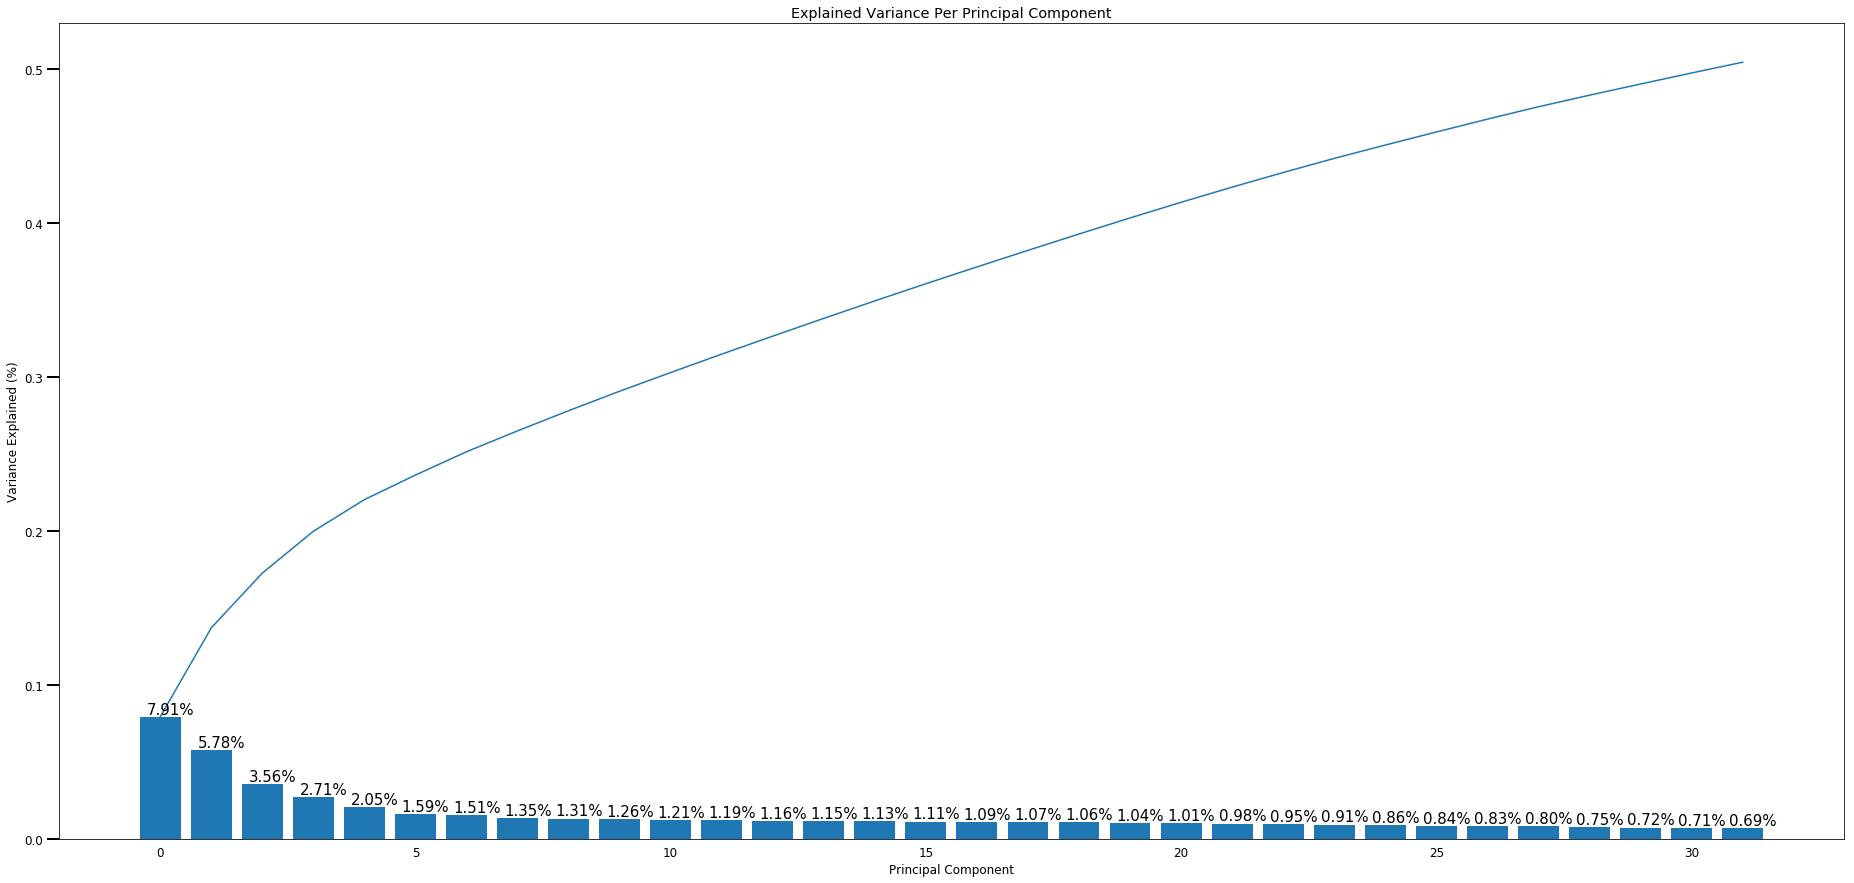

In [69]:
# Investigate the variance accounted for by each principal component.

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)//3
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_[:int(len(pca.explained_variance_ratio_)//3)]
 
    plt.figure(figsize=(32, 15))
    
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=15)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
scree_plot(pca_o)

In [39]:
print(np.where(pca_o.explained_variance_ratio_ > 0.01))
print(pca_o.explained_variance_ratio_[:21].cumsum())

# Based on the graph, we can see that the explained variances are flatter than we would like.
# Choosing the first 21 components seems to be a decent balance between capturing more variance
# and limiting noise. 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20]),)
[ 0.07918653  0.13701937  0.17262672  0.19982053  0.22037875  0.23635667
  0.25149834  0.26504067  0.27817841  0.29083328  0.30298036  0.31493356
  0.32662967  0.33817888  0.34953854  0.36068854  0.37159943  0.38238116
  0.39300878  0.40343715  0.4136262 ]


In [40]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca_o21, X_pca21 = do_pca(21, azdias_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

<b>1. Based on the graph, we can see that the explained variances are flatter than we would like. Choosing the number of PCs is more difficult.


<b>2. So arbitrarily I decided to keep the PCs that explain atleast 1% of the variance. These are the first 21 components which explain about 41% of the variance. This seems to have a good balance between capturing more variance and picking PCs that only contribute to noise. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,...,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DEC,PRAEGENDE_JUGENDJAHRE_MOV,CAMEO_INTL_2015_LS,CAMEO_INTL_2015_WE
Dimension 1,0.0792,-0.0846,0.0147,-0.1922,0.1156,-0.0843,0.0560,0.0516,0.1497,-0.1053,0.0257,-0.0098,0.0247,0.0523,0.0798,...,0.0117,0.0019,0.0643,0.0427,0.0342,0.0257,0.0391,0.0577,0.0585,0.0580,0.0168,0.0737,0.1029,-0.1115,0.1867
Dimension 2,0.0578,0.2330,0.0393,0.0869,-0.2267,0.2190,-0.2033,-0.2155,0.0880,-0.0085,-0.0520,0.1558,-0.0620,-0.1339,-0.2139,...,0.0111,0.0123,0.0164,0.0101,0.0165,0.0354,-0.0055,0.0032,0.0074,0.0133,0.0390,-0.2379,0.0074,0.0103,0.0600
Dimension 3,0.0356,0.0156,-0.3455,0.1289,-0.0555,0.0469,-0.1528,-0.0468,-0.0603,0.0736,-0.0085,0.0750,0.2572,0.2610,0.1136,...,0.0020,0.0015,0.0082,0.0186,-0.0053,0.0004,-0.0037,0.0128,0.0255,0.0120,-0.0014,-0.0504,-0.0712,-0.0156,0.0189
Dimension 4,0.0272,-0.0227,0.0844,-0.0032,0.0098,-0.0144,-0.0624,0.0564,-0.0221,0.2940,-0.0077,-0.0049,-0.0298,-0.0616,-0.0284,...,0.0009,-0.0055,-0.0078,0.0266,-0.0186,-0.0168,-0.0050,-0.0069,0.0051,-0.0032,0.0031,0.0300,-0.2947,0.0284,-0.0626
Dimension 5,0.0206,0.0488,-0.0267,0.0487,-0.0265,0.0313,0.0252,-0.0966,-0.0386,-0.1203,0.0038,0.0056,0.0129,-0.0146,-0.0344,...,-0.0060,0.0023,0.0461,-0.0228,0.0525,0.0291,0.0613,0.0367,0.0176,0.0200,-0.0077,-0.0133,0.1236,-0.0598,0.1067


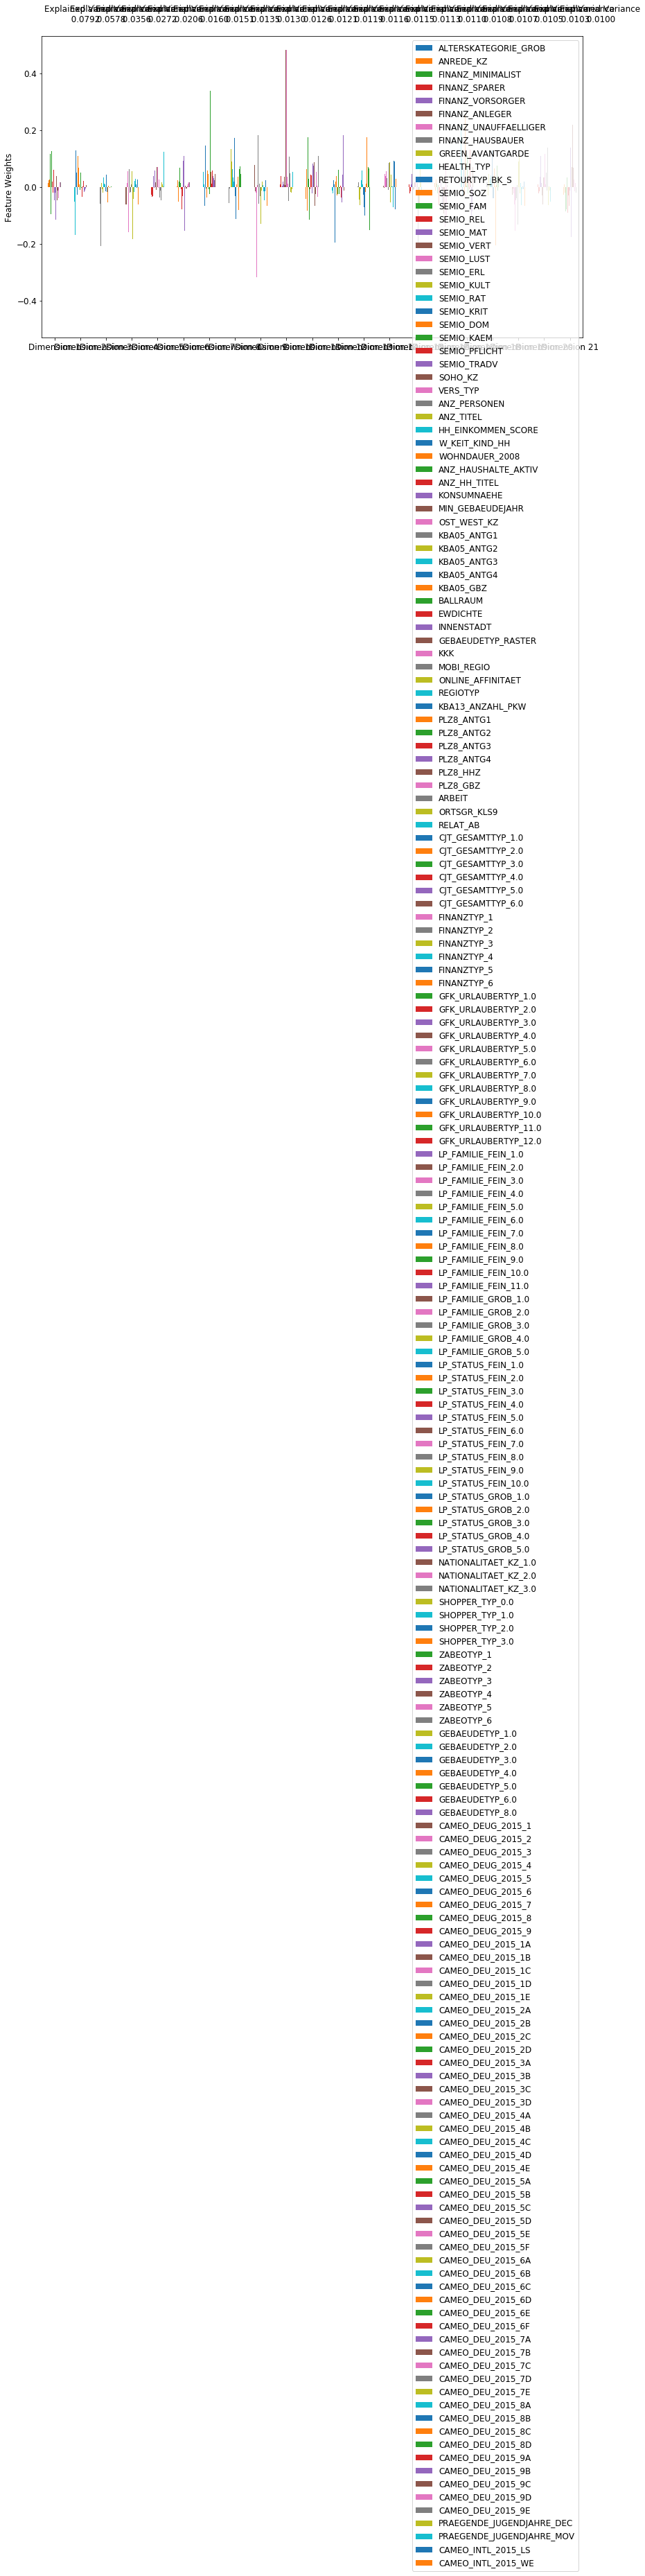

In [70]:
#First get the dataframe of PC vs feature weights

def pca_results(full_dataset, pca):
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Create a bar plot visualization
	fig, ax = plt.subplots(figsize = (14,8))

	# Plot the feature weights as a function of the components
	components.plot(ax = ax, kind = 'bar');
	ax.set_ylabel("Feature Weights")
	ax.set_xticklabels(dimensions, rotation=0)


	# Display the explained variance ratios
	for i, ev in enumerate(pca.explained_variance_ratio_):
		ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)

pca_res = pca_results(azdias_scaled, pca_o21)
pca_res.head()

'Dimension 1'

MOBI_REGIO           -0.2052
LP_STATUS_GROB_1.0    0.1967
KBA05_ANTG1          -0.1923
FINANZ_MINIMALIST    -0.1922
HH_EINKOMMEN_SCORE    0.1869
CAMEO_INTL_2015_WE    0.1867
PLZ8_ANTG1           -0.1832
PLZ8_ANTG3            0.1825
KBA05_GBZ            -0.1823
PLZ8_ANTG4            0.1766
Name: Dimension 1, dtype: float64

LP_STATUS_GROB_1.0    0.1967
HH_EINKOMMEN_SCORE    0.1869
CAMEO_INTL_2015_WE    0.1867
PLZ8_ANTG3            0.1825
PLZ8_ANTG4            0.1766
Name: Dimension 1, dtype: float64

MOBI_REGIO          -0.2052
KBA05_ANTG1         -0.1923
FINANZ_MINIMALIST   -0.1922
PLZ8_ANTG1          -0.1832
KBA05_GBZ           -0.1823
Name: Dimension 1, dtype: float64

'Dimension 2'

PRAEGENDE_JUGENDJAHRE_DEC   -0.2379
ALTERSKATEGORIE_GROB         0.2330
FINANZ_SPARER               -0.2267
FINANZ_VORSORGER             0.2190
FINANZ_UNAUFFAELLIGER       -0.2155
SEMIO_REL                   -0.2139
SEMIO_TRADV                 -0.2081
SEMIO_PFLICHT               -0.2049
FINANZ_ANLEGER              -0.2033
ZABEOTYP_3                   0.2002
Name: Dimension 2, dtype: float64

ALTERSKATEGORIE_GROB    0.2330
FINANZ_VORSORGER        0.2190
ZABEOTYP_3              0.2002
Name: Dimension 2, dtype: float64

PRAEGENDE_JUGENDJAHRE_DEC   -0.2379
FINANZ_SPARER               -0.2267
FINANZ_UNAUFFAELLIGER       -0.2155
SEMIO_REL                   -0.2139
SEMIO_TRADV                 -0.2081
SEMIO_PFLICHT               -0.2049
FINANZ_ANLEGER              -0.2033
Name: Dimension 2, dtype: float64

'Dimension 3'

ANREDE_KZ    -0.3455
SEMIO_VERT    0.3191
SEMIO_KAEM   -0.3157
SEMIO_DOM    -0.2842
SEMIO_KRIT   -0.2672
SEMIO_FAM     0.2610
SEMIO_SOZ     0.2572
SEMIO_KULT    0.2519
SEMIO_ERL    -0.2083
SEMIO_RAT    -0.1548
Name: Dimension 3, dtype: float64

SEMIO_VERT    0.3191
SEMIO_FAM     0.2610
SEMIO_SOZ     0.2572
SEMIO_KULT    0.2519
Name: Dimension 3, dtype: float64

ANREDE_KZ    -0.3455
SEMIO_KAEM   -0.3157
SEMIO_DOM    -0.2842
SEMIO_KRIT   -0.2672
SEMIO_ERL    -0.2083
SEMIO_RAT    -0.1548
Name: Dimension 3, dtype: float64

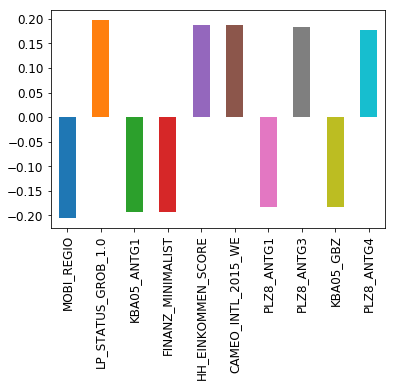

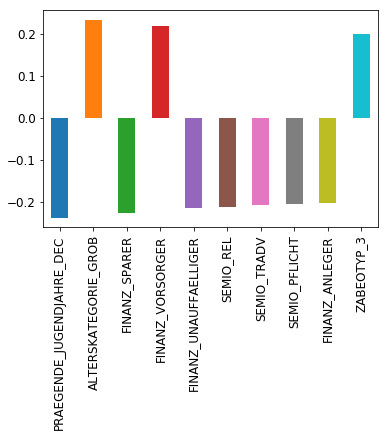

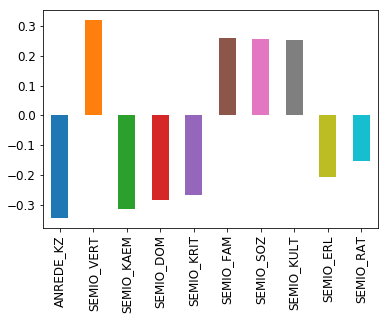

In [72]:
# Map weights for the first,second and third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

for index, dim in pca_res.head(3).iterrows():
    dim = dim[1:].loc[dim[1:].abs().nlargest(10).index]
    dim_pos = dim.loc[dim>0]
    dim_neg = dim.loc[dim<0]
    
    fig, ax = plt.subplots()
    
    dim.plot('bar')
    dis(index,dim,dim_pos,dim_neg)

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

The first 3 PCs are highly instructive and provide a good characterization of individuals as well as pointing at important correlations.

<b> 
 
1. PC 1 (Poor)
   
   PC 1 is correlated with features describing poverty.
   
   Characteristics:
       1. Earning: low income, low household income, poor households
       2. family size: large
       3. movement: highly mobile
       4. financial interest: low
       5. number of buildings in area: low
       
       
2. PC 2 (Rich,Old)

   PC 2 is correlated with features of wealth and age.
   
   Characteristics:
       1. Age: Old
       2. Energy consumption: high (indifferent)
       3. Finances: tend to spend, save and invest more (indicating high income/wealth)
       4. Religiousity: Highly religious
       
      
3. PC 3 (Male)

   PC 3 seems to isolate males and their typical personality type.
   
   Characteristics:
       1. Gender: Male
       2. Personality - Less family-minded, social and cultural. More rational, dominant and combative
</b>

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [73]:
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

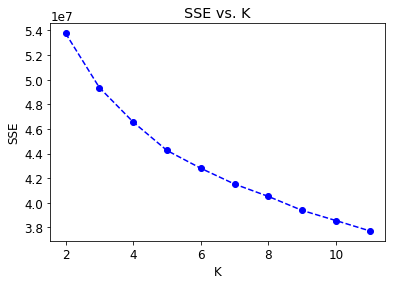

In [74]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

# This step takes a while

scores = []
centers = list(range(2,12))

for i in centers:
    scores.append(get_kmeans_score(X_pca21, i))
    
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [75]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# It looks like a number between 5 and 7 would be good for the number of clusters
# as there is no clear elbow point. We'll take 7

kmeans = KMeans(n_clusters = 7) 
model = kmeans.fit(X_pca21) 

azdias_clust = model.predict(X_pca21)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

<b> K-means clustering was performed on the PCA data. However, there was no clear elbow point. So the number of clusters was taken to be 7 based on approximation. Also the computing power was limited to seeing clusters only upto 11.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [76]:
# Load in the customer demographics data.
cust = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')

dis(cust.head())
dis(cust.info())
print(cust.shape)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,...,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,...,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,...,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,6,0,10.0,0,2,...,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,2,1960,2.0,0,3,...,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 85 columns):
AGER_TYP                 191652 non-null int64
ALTERSKATEGORIE_GROB     191652 non-null int64
ANREDE_KZ                191652 non-null int64
CJT_GESAMTTYP            188439 non-null float64
FINANZ_MINIMALIST        191652 non-null int64
FINANZ_SPARER            191652 non-null int64
FINANZ_VORSORGER         191652 non-null int64
FINANZ_ANLEGER           191652 non-null int64
FINANZ_UNAUFFAELLIGER    191652 non-null int64
FINANZ_HAUSBAUER         191652 non-null int64
FINANZTYP                191652 non-null int64
GEBURTSJAHR              191652 non-null int64
GFK_URLAUBERTYP          188439 non-null float64
GREEN_AVANTGARDE         191652 non-null int64
HEALTH_TYP               191652 non-null int64
LP_LEBENSPHASE_FEIN      188439 non-null float64
LP_LEBENSPHASE_GROB      188439 non-null float64
LP_FAMILIE_FEIN          188439 non-null float64
LP_FAMILIE_GROB          188439 n

None

(191652, 85)


In [77]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

cust_,more_than_c = clean_data(cust)
dis(more_than_c.shape[0])
cust_.head()

The shape of the original dataframe: (191652, 85)


'The original dataframe:'

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,...,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,...,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,...,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,6,0,10.0,0,2,...,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,2,1960,2.0,0,3,...,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


'dataframe with missing values removed:'

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,...,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,4.0,1,5.0,5,1,5,1,2,2,2,NaN,4.0,1,1.0,...,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,NaN,4.0,1,NaN,5,1,5,1,3,2,2,NaN,NaN,0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,4.0,2,2.0,5,1,5,1,4,4,2,NaN,3.0,1,2.0,...,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1.0,4.0,1,2.0,5,1,5,2,1,2,6,NaN,10.0,0,2.0,...,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,NaN,3.0,1,6.0,3,1,4,4,5,2,2,1960.0,2.0,0,3.0,...,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


'columns to remove:'

TITEL_KZ        99.757636
AGER_TYP        76.955435
KK_KUNDENTYP    65.596749
KBA05_BAUMAX    53.468668
GEBURTSJAHR     44.020282
ALTER_HH        34.813699
dtype: float64

'Shape after dropping columns:'

(191652, 79)

Shape after dropping rows: (141590, 79)


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Shape after dealing with categoricals: (141590, 193)
Shape after removing 4 mixed columns: (141590, 189)
{1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 7: 3, 8: 4, 9: 4, 10: 5, 11: 5, 12: 5, 13: 5, 14: 6, 15: 6}
{1: 1, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 0, 8: 1, 9: 0, 10: 1, 11: 0, 12: 1, 13: 0, 14: 1, 15: 0}
Shape after reencoding mixed variables: (141590, 191)


50062

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,...,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DEC,PRAEGENDE_JUGENDJAHRE_MOV,CAMEO_INTL_2015_LS,CAMEO_INTL_2015_WE
0,4.0,1,5,1,5,1,2,2,1,1.0,5.0,6,5,2,6,...,0,0,0,0,0,0,0,0,0,0,0,2.0,0.0,3.0,1.0
2,4.0,2,5,1,5,1,4,4,1,2.0,5.0,2,2,1,3,...,0,0,0,0,0,0,0,0,0,0,0,2.0,0.0,4.0,3.0
3,4.0,1,5,1,5,2,1,2,0,2.0,3.0,6,5,3,4,...,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,4.0,2.0
4,3.0,1,3,1,4,4,5,2,0,3.0,5.0,4,5,4,6,...,0,0,0,0,0,0,0,0,0,0,0,4.0,1.0,1.0,4.0
5,3.0,1,5,1,5,1,2,3,1,3.0,3.0,6,4,4,1,...,0,0,0,0,0,0,0,0,0,0,0,2.0,0.0,4.0,3.0


In [78]:
# There seems to be one column that is missing. There is one categorical that has not been generated 
# by one hot encoding. 

# To find missing column
dis(list(set(azdias_scaled.columns) - set(cust_.columns)))

['GEBAEUDETYP_5.0']

In [79]:
#Add missing column in cust
dis(cust_.columns.get_loc('GEBAEUDETYP_4.0'))
dis(cust_.columns.get_loc('GEBAEUDETYP_6.0'))

cust_.insert(loc = 132, column = 'GEBAEUDETYP_5.0', value = 0)
dis(cust_.columns.get_loc('GEBAEUDETYP_4.0'))
dis(cust_.columns.get_loc('GEBAEUDETYP_6.0'))

cust_['GEBAEUDETYP_5.0'][:5]

131

132

131

133

In [80]:
#Remove nans

print(100*(cust_.size - cust_.count().sum())/cust_.size)

#The number of missing values is about 0.5%. Imputing is the standard option.

#Applying mean imputation
cust_clean = cust_.fillna(cust_.mean())

#Confirming that there are no nan values
cust_clean.isnull().values.any()

0.375501006427


False

In [81]:
cust_scaled = pd.DataFrame(scale.fit_transform(cust_clean),columns = azdias_clean.columns)
dis(cust_clean.head())
cust_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,...,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DEC,PRAEGENDE_JUGENDJAHRE_MOV,CAMEO_INTL_2015_LS,CAMEO_INTL_2015_WE
0,4.0,1,5,1,5,1,2,2,1,1.0,5.0,6,5,2,6,...,0,0,0,0,0,0,0,0,0,0,0,2.0,0.0,3.0,1.0
2,4.0,2,5,1,5,1,4,4,1,2.0,5.0,2,2,1,3,...,0,0,0,0,0,0,0,0,0,0,0,2.0,0.0,4.0,3.0
3,4.0,1,5,1,5,2,1,2,0,2.0,3.0,6,5,3,4,...,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,4.0,2.0
4,3.0,1,3,1,4,4,5,2,0,3.0,5.0,4,5,4,6,...,0,0,0,0,0,0,0,0,0,0,0,4.0,1.0,1.0,4.0
5,3.0,1,5,1,5,1,2,3,1,3.0,3.0,6,4,4,1,...,0,0,0,0,0,0,0,0,0,0,0,2.0,0.0,4.0,3.0


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,...,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_DEC,PRAEGENDE_JUGENDJAHRE_MOV,CAMEO_INTL_2015_LS,CAMEO_INTL_2015_WE
0,0.703101,-0.70280,0.723000,-0.516937,0.516188,-0.600675,0.138290,-0.553522,1.006178,-1.255787,0.923279,1.032369,0.657199,-0.813797,1.267701,...,-0.075381,-0.085645,-0.175934,-0.165707,-0.142011,-0.125776,-0.085225,-0.080738,-0.083784,-0.118356,-0.103616,-0.662333,-1.001684,-0.275297,-1.140266
1,0.703101,1.42288,0.723000,-0.516937,0.516188,-0.600675,2.183668,0.965412,1.006178,0.048907,0.923279,-1.438336,-1.125456,-1.498963,-0.245631,...,-0.075381,-0.085645,-0.175934,-0.165707,-0.142011,-0.125776,-0.085225,-0.080738,-0.083784,-0.118356,-0.103616,-0.662333,-1.001684,0.472411,0.286327
2,0.703101,-0.70280,0.723000,-0.516937,0.516188,0.397173,-0.884400,-0.553522,-0.993860,0.048907,-0.782269,1.032369,0.657199,-0.128632,0.258813,...,-0.075381,-0.085645,-0.175934,-0.165707,-0.142011,-0.125776,-0.085225,-0.080738,-0.083784,-0.118356,-0.103616,-1.408340,1.007325,0.472411,-0.426969
3,-0.668472,-0.70280,-1.242075,-0.516937,-0.665858,2.392870,3.206358,-0.553522,-0.993860,1.353601,0.923279,-0.202984,0.657199,0.556533,1.267701,...,-0.075381,-0.085645,-0.175934,-0.165707,-0.142011,-0.125776,-0.085225,-0.080738,-0.083784,-0.118356,-0.103616,0.829680,1.007325,-1.770713,0.999624
4,-0.668472,-0.70280,0.723000,-0.516937,0.516188,-0.600675,0.138290,0.205945,1.006178,1.353601,-0.782269,1.032369,0.062981,0.556533,-1.254519,...,-0.075381,-0.085645,-0.175934,-0.165707,-0.142011,-0.125776,-0.085225,-0.080738,-0.083784,-0.118356,-0.103616,-0.662333,-1.001684,0.472411,0.286327


In [82]:
cust_pca = pca_o21.transform(cust_scaled)
cust_cluster = model.predict(cust_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [83]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

cust_cldf = pd.DataFrame(cust_cluster, columns = ['customers_clusters'])
c_clustcount = cust_cldf['customers_clusters'].value_counts()
dis(c_clustcount.sort_index())


azdias_cldf = pd.DataFrame(azdias_clust, columns = ['general_clusters'])
g_clustcount = azdias_cldf['general_clusters'].value_counts()
dis(g_clustcount.sort_index())

0    32268
1    26239
2     8554
3    19789
4    13146
5    24618
6    16976
Name: customers_clusters, dtype: int64

0    109358
1    141343
2    133615
3    116452
4     99999
5    119017
6     77293
Name: general_clusters, dtype: int64

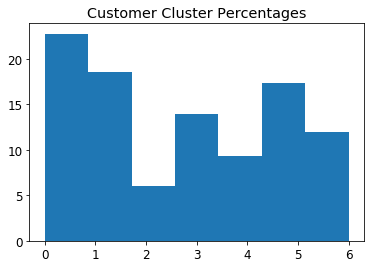

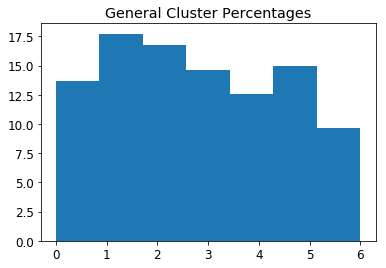

0    22.789745
1    18.531676
2     6.041387
3    13.976270
4     9.284554
5    17.386821
6    11.989547
Name: customers_clusters, dtype: float64

0    13.719879
1    17.732666
2    16.763123
3    14.609881
4    12.545714
5    14.931682
6     9.697056
Name: general_clusters, dtype: float64

In [84]:
#Without anomaly rows

cn_clustcount = (100*c_clustcount/c_clustcount.sum()).sort_index()
plt.hist(cn_clustcount.index,weights=cn_clustcount.values,range=(0,6),bins=7)
plt.title('Customer Cluster Percentages')
plt.show()

gn_clustcount = (100*g_clustcount/g_clustcount.sum()).sort_index()
plt.hist(gn_clustcount.index,weights=gn_clustcount.values,range=(0,6),bins=7)
plt.title('General Cluster Percentages')
plt.show()

dis(cn_clustcount,gn_clustcount)

In [90]:
diff = cn_clustcount/gn_clustcount
over_rep = diff.nlargest(1).index[0]
under_rep = diff.nsmallest(1).index[0]
print('Cluster with highest ratio in customers:',over_rep,'\n'
    'Cluster with lowest ratio in customers:',under_rep)

Cluster with highest ratio in customers: 0 
Cluster with lowest ratio in customers: 2


In [86]:
#Appending anomaly rows

cm_clustcount = c_clustcount.append(pd.Series(more_than_c.shape[0], index=[7])).sort_index()
dis(cm_clustcount)

gm_clustcount = g_clustcount.append(pd.Series(more_than19.shape[0], index=[7])).sort_index()
gm_clustcount

0    32268
1    26239
2     8554
3    19789
4    13146
5    24618
6    16976
7    50062
dtype: int64

0    109358
1    141343
2    133615
3    116452
4     99999
5    119017
6     77293
7     94144
dtype: int64

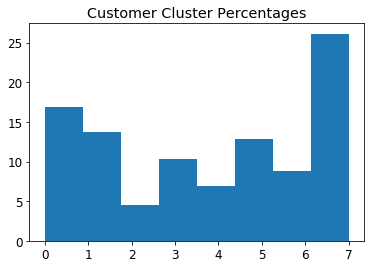

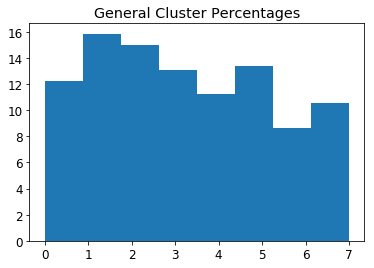

0    16.836767
1    13.690961
2     4.463298
3    10.325486
4     6.859307
5    12.845157
6     8.857721
7    26.121303
dtype: float64

0    12.270582
1    15.859478
2    14.992353
3    13.066568
4    11.220449
5    13.354376
6     8.672709
7    10.563485
dtype: float64

In [87]:
#With anomaly rows

cm_clustcount = 100*cm_clustcount/cm_clustcount.sum()
plt.hist(cm_clustcount.index,weights=cm_clustcount.values,range=(0,7),bins=8)
plt.title('Customer Cluster Percentages')
plt.show()

gm_clustcount = 100*gm_clustcount/gm_clustcount.sum()
plt.hist(gm_clustcount.index,weights=gm_clustcount.values,range=(0,7),bins=8)
plt.title('General Cluster Percentages')
plt.show()
g_clustcount

dis(cm_clustcount,gm_clustcount)

In [88]:
diff = cm_clustcount/gm_clustcount
print('Cluster with highest ratio in customers:',diff.nlargest(1).index[0],'\n'
    'Cluster with lowest ratio in customers:',diff.nsmallest(1).index[0])

Cluster with highest ratio in customers: 7 
Cluster with lowest ratio in customers: 2


In [93]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Analyzing cluster with overrepresentation in customers dataset

dis(azdias_scaled.shape,azdias_clust.shape)
diff = azdias_scaled.loc[azdias_clust == over_rep].median(axis=0) - azdias_scaled.median(axis=0)
diff = diff.loc[diff.abs().nlargest(15).index]
diff

(797077, 192)

(797077,)

LP_STATUS_FEIN_10.0          2.882523
LP_STATUS_GROB_5.0           2.882523
PRAEGENDE_JUGENDJAHRE_MOV   -2.427748
GREEN_AVANTGARDE             2.415121
LP_FAMILIE_FEIN_1.0         -2.000087
LP_FAMILIE_GROB_1.0         -2.000087
HH_EINKOMMEN_SCORE          -1.941712
KBA05_ANTG1                  1.460903
FINANZ_MINIMALIST            1.451832
PLZ8_ANTG4                  -1.394979
CAMEO_INTL_2015_WE          -1.370676
FINANZ_ANLEGER              -1.358210
FINANZ_SPARER               -1.346773
REGIOTYP                    -1.135794
SEMIO_ERL                    1.094867
dtype: float64

In [94]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Analyzing cluster with underrepresentation in customers dataset

dis(azdias_scaled.shape,azdias_clust.shape)
diff = azdias_scaled.loc[azdias_clust == under_rep].median(axis=0) - azdias_scaled.median(axis=0)
diff = diff.loc[diff.abs().nlargest(15).index]
diff

(797077, 192)

(797077,)

LP_STATUS_FEIN_2.0           2.888192
FINANZTYP_1                  2.319040
LP_STATUS_GROB_1.0           2.042369
GEBAEUDETYP_1.0             -2.024091
SEMIO_VERT                  -1.542561
FINANZ_VORSORGER            -1.452477
FINANZ_MINIMALIST           -1.451832
FINANZ_UNAUFFAELLIGER        1.429473
BALLRAUM                    -1.374270
CAMEO_INTL_2015_LS          -1.351887
FINANZ_SPARER                1.346773
PRAEGENDE_JUGENDJAHRE_DEC    1.165504
EWDICHTE                     1.163911
GEBAEUDETYP_RASTER          -1.083324
SEMIO_PFLICHT                1.078226
dtype: float64

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)
<b>

1. Cluster 0, popular with company

   Characteristics:
       1. Income: High Income, High Household income, Wealthy households
       2. Financial: High financial interest, invest and save more
       3. Neighborhoud: low density, wealthy households
       4. Ideology: Avantgarde, green and sustainable
       5. Relationship Status: Single

2. Cluster 2, unpopular with company

   Characteristics:
       1. Income: Low income
       2. Financial: Low financial interest, low spenders
       3. Neighboorhoud: dense neighborhouds
       3. Personality: dreamy, dutiful
       4. Location: Live near urban centres
       5. Relationship Status: Single or pre-family couple
       6. Age: Young

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.